# **EDA for Battle ground data**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

train = pd.read_csv("train_V2.csv")


# **Correlation of Variables**

ValueError: could not convert string to float: '7f96b2f878858a'

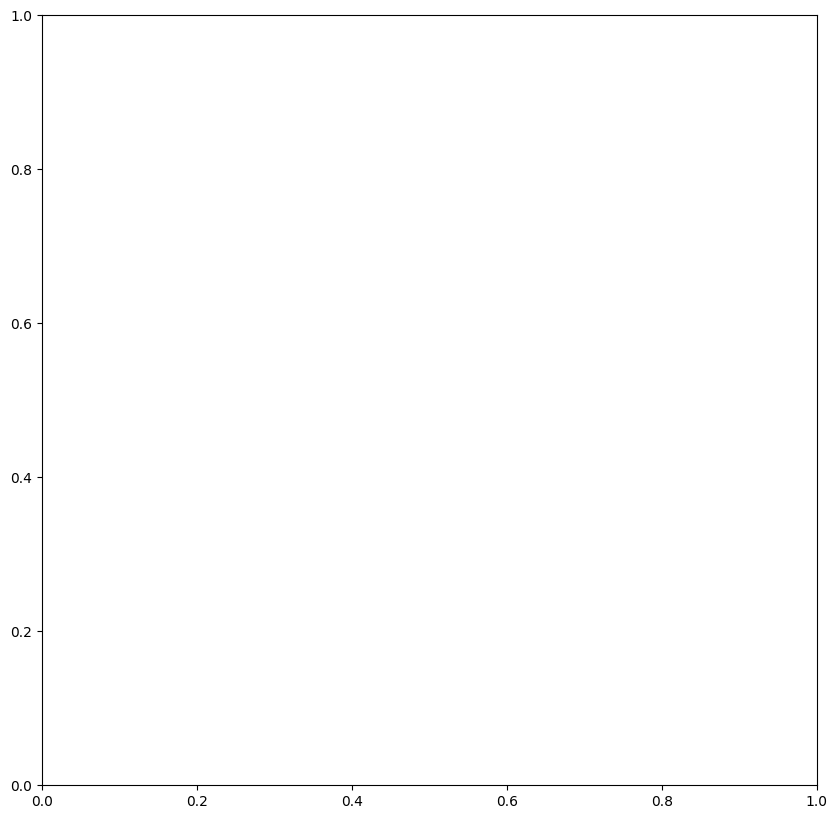

In [7]:
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(train.corr(), annot=True, linewidths=.5, fmt='.1f', ax=ax)
plt.show()

Among lots of variables, **walkDistance**, **boosts** have large correlation with **winPlacePerc**
* walkDistance : Total distance traveled on foot measured in meters.
* boosts : Number of boost items used.
* winPlacePerc : The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

Now let's see the correlation betwwen 'winPlacePerc' and others

In [8]:
corr_rank = train.corr()["winPlacePerc"].sort_values(ascending=False)
print(corr_rank)

ValueError: could not convert string to float: '7f96b2f878858a'

I expected that **'kills'** is the most significant variable.  
But no, it has a bit smaller correlation than **walkDistance**.  
So first of all check the **kills** variable

In [19]:
# sum functions
def simple_shot(var):
    print('mean value of {} : {}'.format(var, train[var].mean()))
    print('median value of {} : {}'.format(var, train[var].median()))
    print('top 1% of {} : {}'.format(var, train[var].quantile(0.99)))
    print('max of {} : {}'.format(var, train[var].max()))
    print('min of {} : {}'.format(var, train[var].min()))

def rank_split(var):
    temp = []
    crit1 = var.quantile(0.2)
    crit2 = var.quantile(0.4)
    crit3 = var.quantile(0.6)
    crit4 = var.quantile(0.8)
    for i in range(len(train)):
        if var[i] <= crit1:
            temp.append(1)
        elif crit1 < var[i] <= crit2:
            temp.append(2)
        elif crit2 < var[i] <= crit3:
            temp.append(3)
        elif crit3 < var[i] <= crit4:
            temp.append(4)
        elif crit4 < var[i]:
            temp.append(5)
    return temp

def split_corr(input_val):
    temp = input_val.stack()
    temp.index = input_val.index
    li = []
    for i in range(1, 6):

        data = temp[i]
        data = data[data.values !=0]
        val = data.values
        idx = data.index
        # val = temp[i].values
        # idx = temp[i].index

        correl = pd.DataFrame([idx, val]).T.corr()
        res = correl[0][1]
        li.append(res)
        print("rank {}'s correlation :{}".format(i, res))
    return li

> # **Kills**  
correlation with Win : 0.419916

In [20]:
simple_shot('kills')

mean value of kills : 0.9247833241810259
median value of kills : 0.0
top 1% of kills : 7.0
max of kills : 72
min of kills : 0


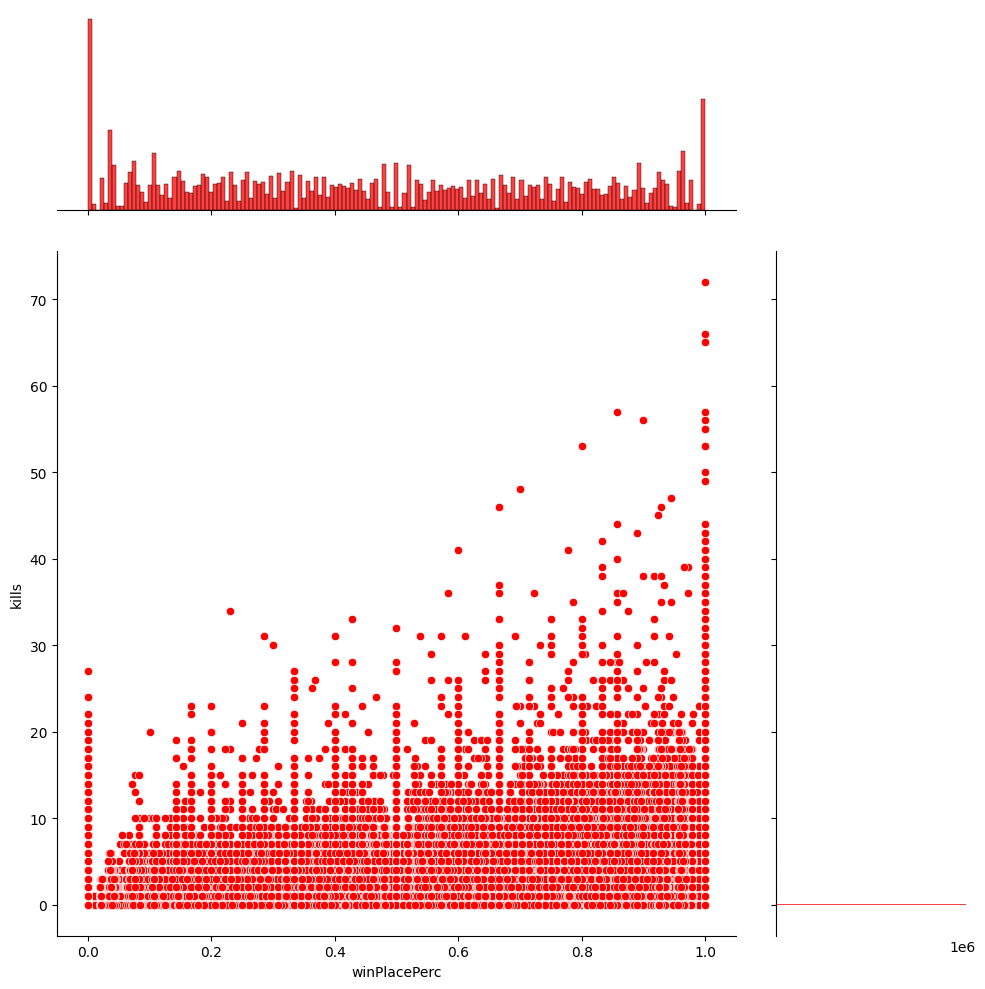

In [21]:
sns.jointplot(x="winPlacePerc", y="kills", data=train, height=10, ratio=3, color="r")
plt.show()

In [22]:
print(train[["winPlacePerc", "kills"]].corr())

              winPlacePerc     kills
winPlacePerc      1.000000  0.419916
kills             0.419916  1.000000


kills-winPlacePerc's correlation is **0.419** which is low.  
I suppose the reason is that the players are groupped by their **rankPoints**  
SO let's split the player with their **rankPoints** and check the correlation between **kills** and **winPercPer**

> ### Split RankPoints in 5 level

In [23]:
simple_shot('rankPoints')
train['rankPoints_split'] = rank_split(train['rankPoints'])
rank_kill_win = train[['winPlacePerc', 'rankPoints_split', 'kills']].groupby(['rankPoints_split', 'kills']).mean()

mean value of rankPoints : 892.0104565674665
median value of rankPoints : 1443.0
top 1% of rankPoints : 1749.0
max of rankPoints : 5910
min of rankPoints : -1


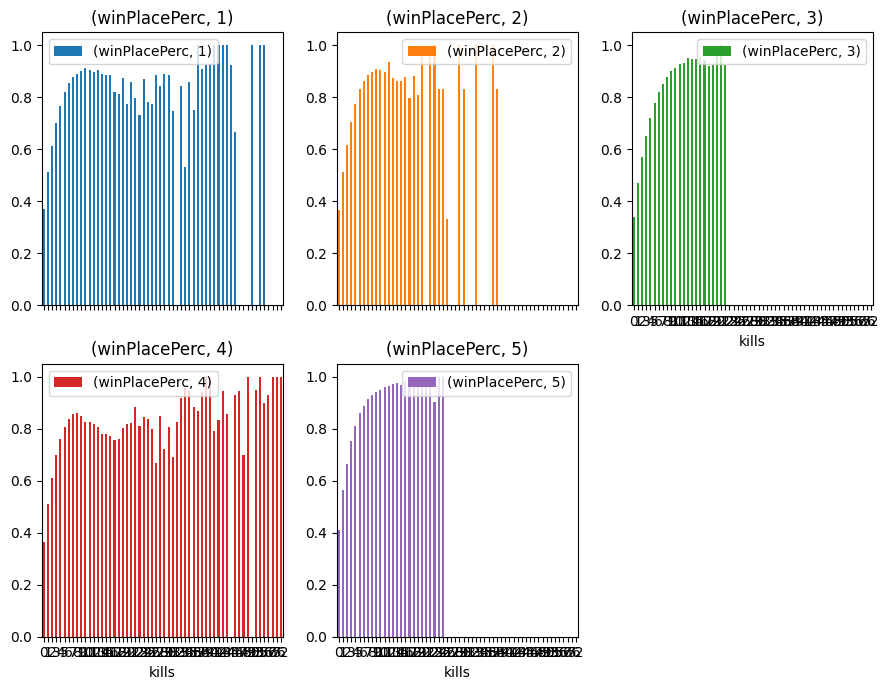

In [24]:
ax = rank_kill_win.unstack(level=0).plot(kind='bar', subplots=True, rot=0, figsize=(9, 7), layout=(2, 3))
plt.tight_layout()


In [25]:
rank_kill_win_corr = split_corr(rank_kill_win)

rank 1's correlation :0.484598889466862
rank 2's correlation :0.3861867708722939
rank 3's correlation :0.822295821244382
rank 4's correlation :0.6696853260185491
rank 5's correlation :0.7572394805003281


rank5 : high, rank1 : low  
higher rank, higher correlation between (**kill** and **win**)


### kills Conclusion  
In high rank, players who fight well are prone to win the game.  
In low rank, fighting skill is not important as in high rank.

# WalkDistance  
**walkDistance** is the most related variable with **winPlacePerc**  
corr : 0.810888

In [26]:
simple_shot('walkDistance')

mean value of walkDistance : 1154.2178590962687
median value of walkDistance : 685.6
top 1% of walkDistance : 4396.0
max of walkDistance : 25780.0
min of walkDistance : 0.0


We can see the distribution of 'walkDistance'(cut off top 1%)

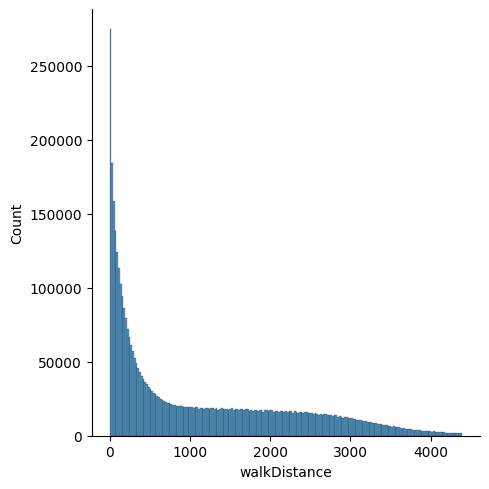

In [27]:
# walkDistance distribution
data = train.copy()
data = data[data['walkDistance'] < train['walkDistance'].quantile(0.99)]
sns.displot(data['walkDistance'])
plt.show()

Let's see the joinplot of (winPlacePerc, walkDistance)

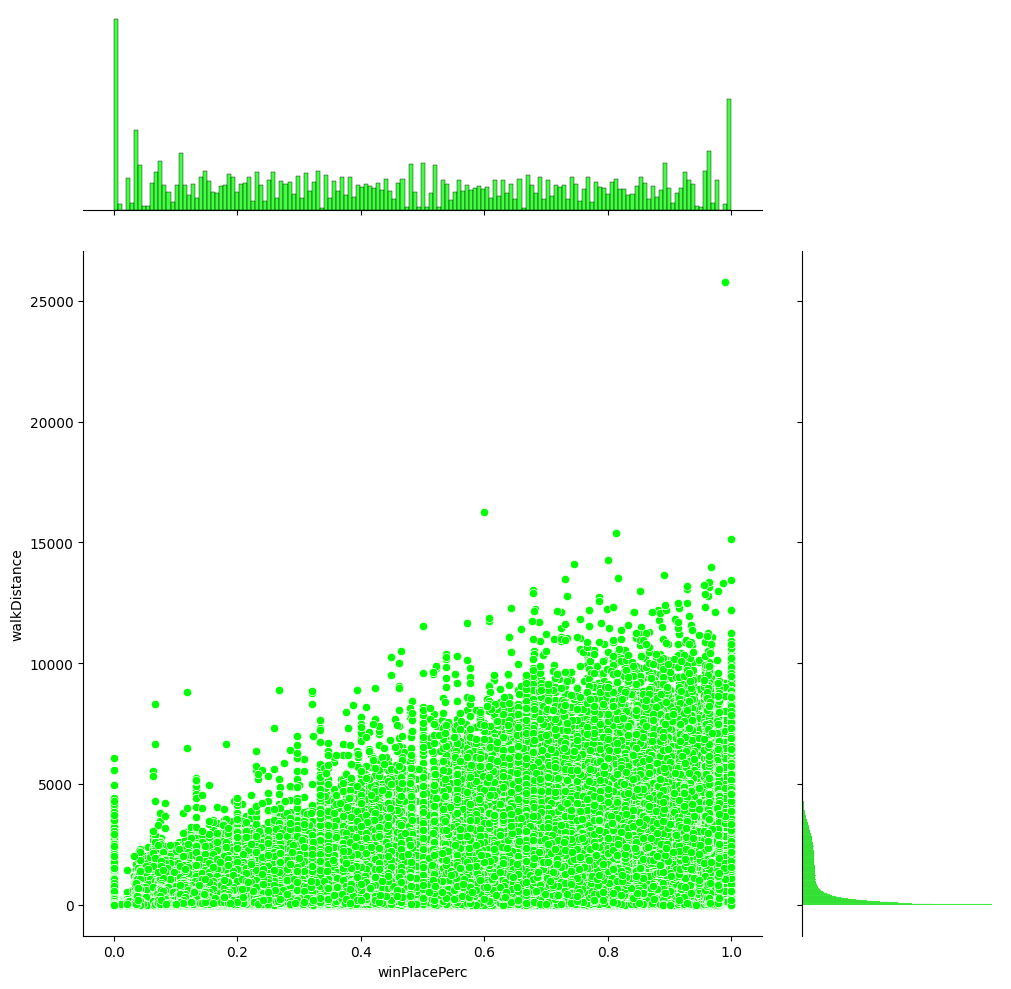

In [28]:
sns.jointplot(x="winPlacePerc", y="walkDistance",  data=train, height=10, ratio=3, color="lime")
plt.show()

> ### Split WalkDistance in 5 levels

Let's see the correlation between (winPlacePerc, walk_split) in the same rank_level(=rankPoints_split)

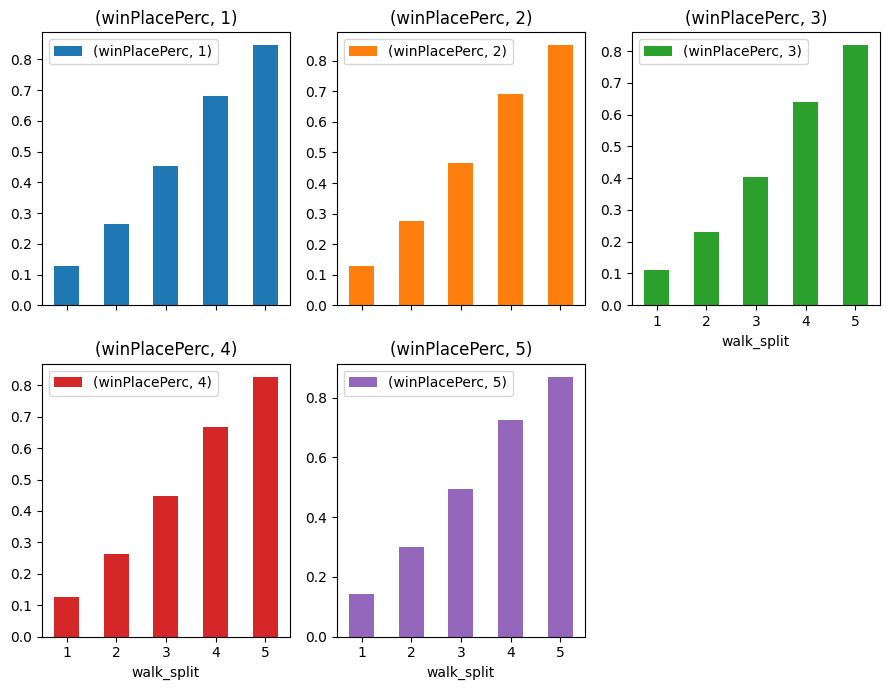

In [29]:
# rank, walk, win
train['walk_split'] = rank_split(train['walkDistance'])
rank_walk_win = train[['winPlacePerc', 'walk_split', 'rankPoints_split']].groupby(['rankPoints_split', 'walk_split']).mean()
ax = rank_walk_win.unstack(level=0).plot(kind='bar', subplots=True, rot=0, figsize=(9, 7), layout=(2, 3))
plt.tight_layout()

It shows us high correlation in every rank

In [30]:
walk_kill_win_corr = split_corr(rank_walk_win) #

rank 1's correlation :0.9970404895476768
rank 2's correlation :0.9977158550893067
rank 3's correlation :0.9944169749375393
rank 4's correlation :0.997311483011917
rank 5's correlation :0.9976898505747664


Let's see the correlation between (kills, winPlacePerc) in the same walk_level(=walk_split)

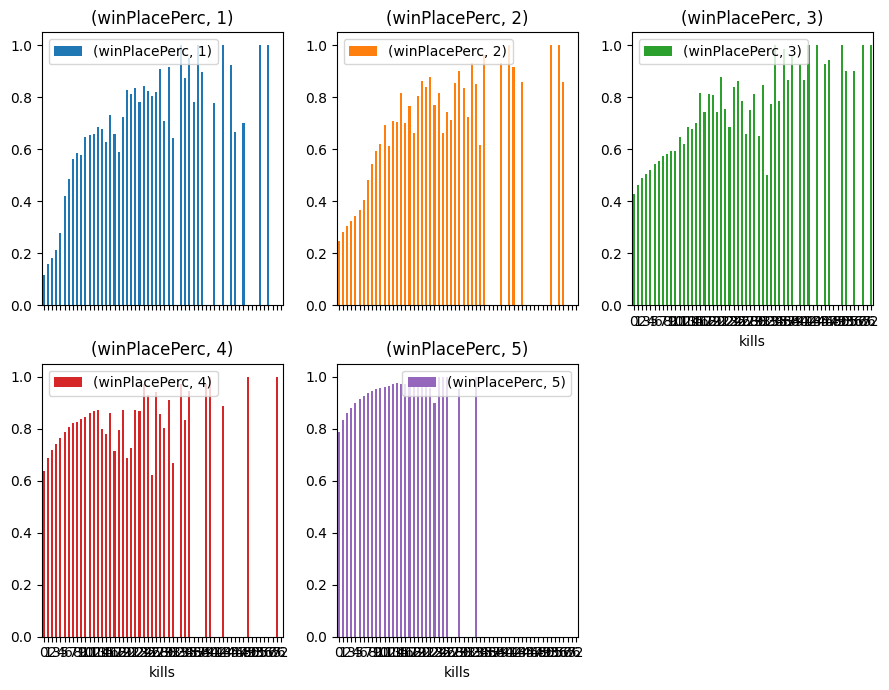

In [31]:
# kill, walk, win
walk_kill_win = train[['winPlacePerc', 'walk_split', 'kills']].groupby(['walk_split', 'kills']).mean()
ax = walk_kill_win.unstack(level=0).plot(kind='bar', subplots=True, rot=0, figsize=(9, 7), layout=(2, 3))
plt.tight_layout() 

With below correlation we can infer that  
hard walker tends to win the game without unnecessary combat.

In [32]:
walk_kill_win_corr = split_corr(walk_kill_win)

rank 1's correlation :0.7873143376486557
rank 2's correlation :0.8245049556161443
rank 3's correlation :0.8391880110583431
rank 4's correlation :0.6097332800763705
rank 5's correlation :0.7448627127528105


> ### the correlation would be different on the number of players
I want to know that whether hard walking winners are team player or not

Split players in (solo and teamplayer) and check the correlation

In [33]:
solos = train[train['numGroups'] > 50]
teamPlayers = train[train['numGroups'] <= 50]

sol_walk_win = solos[['walk_split', 'winPlacePerc']].groupby(['walk_split']).mean()
team_walk_win = teamPlayers[['walk_split', 'winPlacePerc']].groupby(['walk_split']).mean()

sol_walk_win_corr = pd.DataFrame([np.arange(1,6), np.squeeze(sol_walk_win.values)]).T.corr()[0][1]
team_walk_win_corr = pd.DataFrame([np.arange(1,6), np.squeeze(team_walk_win.values)]).T.corr()[0][1]

sol_walk_kill_win = solos[['walk_split', 'winPlacePerc', 'kills']].groupby(['walk_split', 'kills']).mean()
team_walk_kill_win = teamPlayers[['walk_split', 'winPlacePerc', 'kills']].groupby(['walk_split', 'kills']).mean()

print('solos')
sol_walk_kill_win_corr = split_corr(sol_walk_kill_win)
print('\nteam')
team_walk_kill_win_corr = split_corr(team_walk_kill_win) 

solos
rank 1's correlation :0.6031732174143138
rank 2's correlation :0.07248570071330987
rank 3's correlation :0.5182278621398864
rank 4's correlation :0.2984180606999567
rank 5's correlation :0.8505259298114769

team
rank 1's correlation :0.7855660116739502
rank 2's correlation :0.8207251332989698
rank 3's correlation :0.8411907222034696
rank 4's correlation :0.6605235518097147
rank 5's correlation :0.6977355571919203


plot the correlation

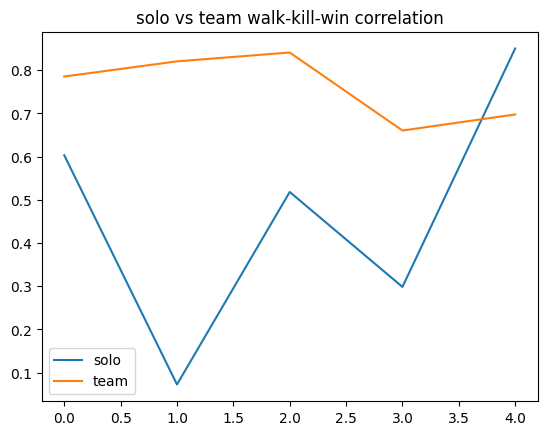

In [34]:
plt.title("solo vs team walk-kill-win correlation")
plt.plot(range(0,5), sol_walk_kill_win_corr, label='solo')
plt.plot(range(0,5), team_walk_kill_win_corr, label='team')
plt.legend()
plt.show()

### kills Conclusion  
* walk is highly correlated with win
* When we split the data with rank level, the correlation between (walk, win) is higher than the prior one
* In teamplayer data, there's a higher correlation between (kill, win) than solos player.
* But 'templaying hard walker' has low correlation between (kill, win).

# Boosts
corr with win : 0.634234

In [35]:
simple_shot('boosts')

mean value of boosts : 1.1069077209045448
median value of boosts : 0.0
top 1% of boosts : 7.0
max of boosts : 33
min of boosts : 0


data distribution of boosts(cut off top 1%)
We can see that most players can't use boost item

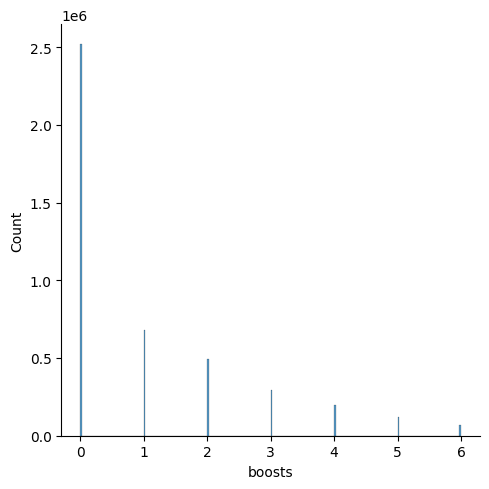

In [36]:
data = train.copy()
data = data[data['boosts'] < train['boosts'].quantile(0.99)]
sns.displot(data['boosts'])
plt.show()

Let's see the joint plot of (winPlacePerc, boosts)

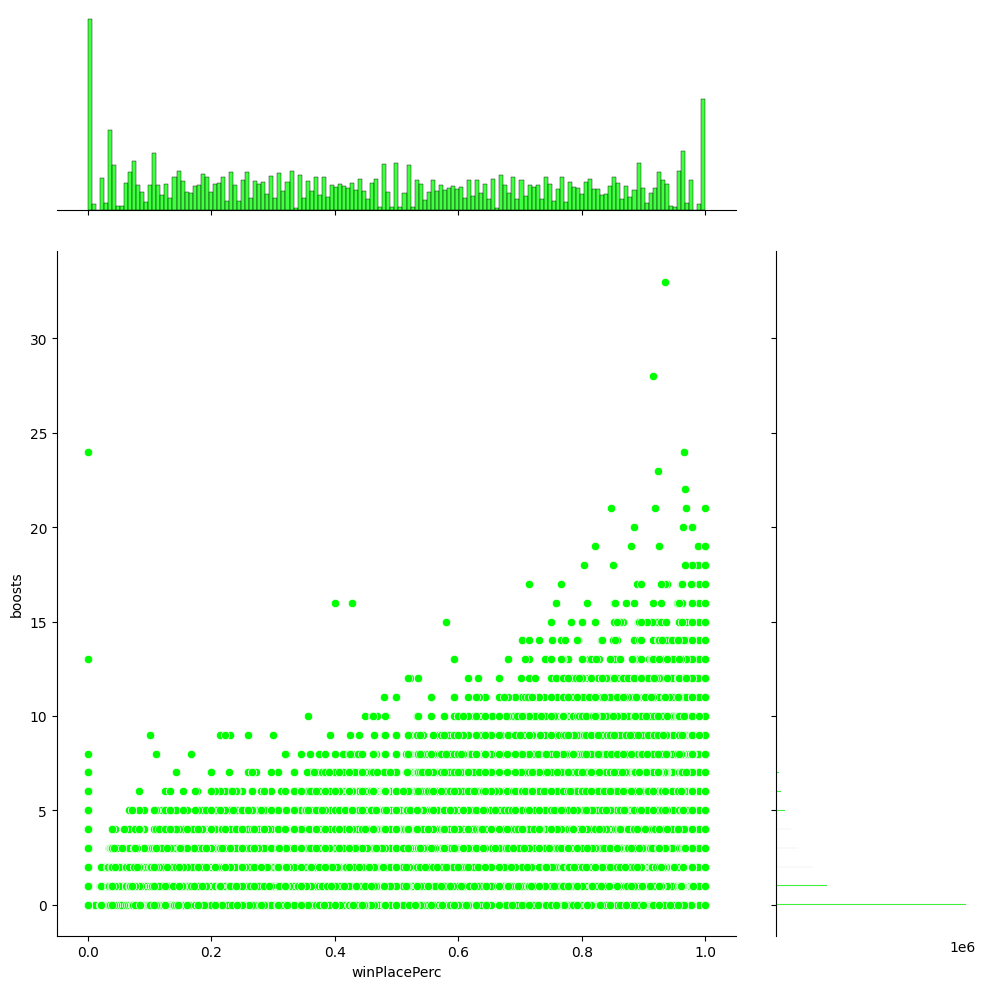

In [37]:
sns.jointplot(x="winPlacePerc", y="boosts",  data=train, height=10, ratio=3, color="lime")
plt.show()

Naturally, correlation between (boosts, winPlacePerc) is high

In [38]:
train['boosts_split'] = rank_split(train['boosts'])
boost_win = train[['winPlacePerc', 'boosts_split']].groupby(['boosts_split']).mean()
boost_win_corr = pd.DataFrame([np.arange(1,6), np.squeeze(boost_win.values)]).T.corr()[0][1]
print('correlation between winPlacePerc and boosts_split :{:.3f}'.format(boost_win_corr, ))

correlation between winPlacePerc and boosts_split :0.985


Let's see the corrletion of (boosts, winPlacePerc) on different level of rank

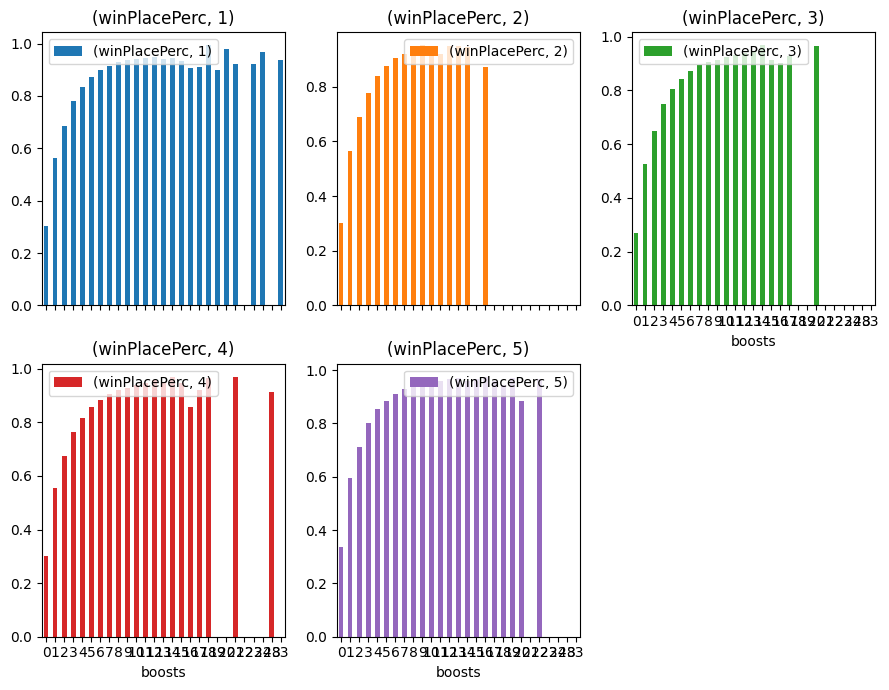

In [39]:

rank_boost_win = train[['winPlacePerc', 'rankPoints_split', 'boosts']].groupby(['rankPoints_split', 'boosts']).mean()
ax = rank_boost_win.unstack(level=0).plot(kind='bar', subplots=True, rot=0, figsize=(9, 7), layout=(2, 3))
plt.tight_layout()

In [40]:
rank_boost_win = split_corr(rank_boost_win)

rank 1's correlation :0.607047483022926
rank 2's correlation :0.7302180334773964
rank 3's correlation :0.7527382433773543
rank 4's correlation :0.6469287326593467
rank 5's correlation :0.6758281232956381


# Let's find cheaters

In [41]:
def rank_10split(var):
    temp = []
    crit1 = var.quantile(0.1)
    crit2 = var.quantile(0.2)
    crit3 = var.quantile(0.3)
    crit4 = var.quantile(0.4)
    crit5 = var.quantile(0.5)
    crit6 = var.quantile(0.6)
    crit7 = var.quantile(0.7)
    crit8 = var.quantile(0.8)
    crit9 = var.quantile(0.9)

    for i in range(len(train)):
        if var[i] <= crit1:
            temp.append(1)
        elif crit1 < var[i] <= crit2:
            temp.append(2)
        elif crit2 < var[i] <= crit3:
            temp.append(3)
        elif crit3 < var[i] <= crit4:
            temp.append(4)
        elif crit4 < var[i] <= crit5:
            temp.append(5)
        elif crit5 < var[i] <= crit6:
            temp.append(6)
        elif crit6 < var[i] <= crit7:
            temp.append(7)
        elif crit7 < var[i] <= crit8:
            temp.append(8)
        elif crit8 < var[i] <= crit9:
            temp.append(9)
        elif crit9 < var[i]:
            temp.append(10)
    return temp

train['walkDistance_split'] = rank_10split(train['walkDistance'])
train['boosts_split'] = rank_10split(train['boosts'])
train['heals_split'] = rank_10split(train['heals'])
train['longestKill_split'] = rank_10split(train['longestKill'])
train = train.drop(['groupId','Id', 'matchId','assists','roadKills', 'vehicleDestroys', 'rideDistance', 'swimDistance'], axis=1)
train_sorted = train.sort_values(by='kills', ascending=False)


**'Boosts'** and **'walkDistance'** are highly correlated with **kills**..  
So I think the people who kill many enemies but don't walk and use boosts are cheaters.  
Let's see the bottom 10% of boosts users and bottom 10% of walkers and high 1% of killers.
Then we can see there are 582 of suspects

In [42]:
train[(train['walkDistance_split'] ==1) & (train['boosts_split'] == 1) & (train['kills'] >= 7)]

,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,...,walkDistance,weaponsAcquired,winPoints,winPlacePerc,rankPoints_split,walk_split,boosts_split,walkDistance_split,heals_split,longestKill_split
11892,0,1750.0,0,4,5,3,0,20,6,37.08,...,0.000,13,0,0.8947,4,1,1,1,9,9
22389,0,1324.0,0,2,0,4,1000,18,3,114.00,...,35.210,28,1500,0.5000,1,1,1,1,1,10
23298,0,1124.0,0,4,1,7,0,12,5,116.30,...,0.000,8,0,0.6000,4,1,1,1,6,10
24640,0,529.9,0,2,11,12,0,7,2,84.37,...,0.000,8,0,0.8571,4,1,1,1,10,10
36345,0,1114.0,0,0,0,4,1000,13,4,30.30,...,0.000,22,1500,1.0000,1,1,1,1,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4396145,0,673.1,0,4,0,22,0,8,3,28.24,...,5.244,20,0,0.1667,4,1,1,1,1,8
4402260,0,1168.0,0,0,0,2,1000,9,2,50.47,...,0.000,13,1500,1.0000,1,1,1,1,1,9
4418082,0,1857.0,0,2,3,15,1000,11,2,132.40,...,0.000,33,1500,0.1429,1,1,1,1,9,10
4420651,0,1340.0,13,2,0,7,0,13,2,81.03,...,0.000,24,0,0.2000,4,1,1,1,1,10


I want to know about the weak healers who don't use heal items.  
Let's see the bottom 10% of heals users and bottom 10% of walkers and high 1% of killers.  
Then we can see there are 582 of suspects

In [43]:
train[(train['walkDistance_split'] == 1) & (train['heals_split'] == 1) & (train['kills'] >= 7)]

,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,...,walkDistance,weaponsAcquired,winPoints,winPlacePerc,rankPoints_split,walk_split,boosts_split,walkDistance_split,heals_split,longestKill_split
22389,0,1324.0,0,2,0,4,1000,18,3,114.00,...,35.210,28,1500,0.5000,1,1,1,1,1,10
36345,0,1114.0,0,0,0,4,1000,13,4,30.30,...,0.000,22,1500,1.0000,1,1,1,1,1,8
50509,0,518.0,0,3,0,8,0,7,3,65.05,...,0.000,14,0,0.6000,4,1,1,1,1,9
57878,0,1458.0,0,6,0,8,1000,18,3,96.01,...,0.000,37,1500,0.2000,1,1,1,1,1,10
104220,0,1249.0,0,7,0,10,1000,11,2,180.00,...,7.970,25,1500,0.5000,1,1,1,1,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4396145,0,673.1,0,4,0,22,0,8,3,28.24,...,5.244,20,0,0.1667,4,1,1,1,1,8
4402260,0,1168.0,0,0,0,2,1000,9,2,50.47,...,0.000,13,1500,1.0000,1,1,1,1,1,9
4420651,0,1340.0,13,2,0,7,0,13,2,81.03,...,0.000,24,0,0.2000,4,1,1,1,1,10
4432354,0,957.2,7,3,0,4,1000,9,2,131.80,...,15.820,22,1500,0.8571,1,1,1,1,1,10


Headshot hunters are probably cheaters.  
It is not easy to record 100% of headshot kill rate(= headshot kills / kills)  
I will check the people 100% headshot killers & top 1% killers  
Then we can see there are 105 of suspects

In [44]:
train['headshot_rate'] = train['headshotKills'] / train['kills']
train[(train['headshot_rate'] >= train['headshot_rate'].quantile(0.9)) & (train['kills']>=7)]

,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,...,weaponsAcquired,winPoints,winPlacePerc,rankPoints_split,walk_split,boosts_split,walkDistance_split,heals_split,longestKill_split,headshot_rate
43791,0,959.4,8,7,0,1,0,7,4,117.70,...,4,0,0.5833,5,4,1,8,1,10,1.0
66266,4,1469.0,9,8,0,2,0,8,1,443.50,...,6,0,0.7200,3,4,9,8,1,10,1.0
102499,1,689.0,0,7,3,16,1000,7,2,155.80,...,12,1500,0.5806,1,5,6,9,9,10,1.0
104571,4,1153.0,0,8,2,1,1212,8,1,189.90,...,4,1513,0.8780,1,4,9,8,8,10,1.0
140178,0,759.6,3,7,0,2,1056,7,7,52.39,...,1,1510,0.6977,1,3,1,5,1,9,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4387092,4,1479.0,0,10,4,1,1496,10,1,136.70,...,8,1560,1.0000,1,5,9,10,9,10,1.0
4408299,11,881.2,7,9,2,1,1664,9,2,58.89,...,5,1556,0.8696,1,5,10,10,8,9,1.0
4417654,7,1083.0,7,7,6,3,0,7,2,103.80,...,3,0,1.0000,5,5,10,9,10,10,1.0
4428741,3,1180.0,7,12,1,1,0,12,2,184.00,...,5,0,0.9375,4,4,9,8,6,10,1.0


I heard that it is not easy to kill others who 800m away.  
SO, I will check the long distance killers who record more than 2 kills.  
Then we can see that there are 16 of suspects

In [45]:
train[(train['longestKill'] > 800)
      & (train['headshot_rate'] >= train['headshot_rate'].quantile(0.9))
      & (train['kills'] > 2)]

,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,...,weaponsAcquired,winPoints,winPlacePerc,rankPoints_split,walk_split,boosts_split,walkDistance_split,heals_split,longestKill_split,headshot_rate
195021,4,784.2,5,4,5,4,1195,4,2,999.9,...,5,1523,0.8485,1,5,9,10,9,10,1.0
632215,0,300.0,3,3,0,13,0,3,2,909.6,...,5,0,0.3200,5,3,1,6,1,10,1.0
654581,0,683.3,2,4,2,4,1102,4,1,990.4,...,5,1433,0.7083,1,4,1,8,8,10,1.0
724327,6,472.5,4,3,1,6,1554,3,1,937.1,...,6,1521,1.0000,1,5,10,10,6,10,1.0
820637,4,485.3,4,3,2,6,1000,3,1,912.2,...,2,1500,1.0000,1,5,9,9,8,10,1.0
1005337,1,503.0,4,3,1,6,1103,3,1,868.7,...,5,1516,1.0000,1,5,6,10,6,10,1.0
1046454,2,865.2,4,6,2,3,1549,6,2,849.6,...,5,1538,0.9231,2,5,8,10,8,10,1.0
1137482,0,168.0,4,3,0,12,0,3,3,851.1,...,6,0,0.4000,5,4,1,7,1,10,1.0
1347404,2,1104.0,0,6,0,3,1181,6,2,921.4,...,3,1507,0.6947,1,4,8,7,1,10,1.0
1552029,1,559.0,4,5,0,4,1000,5,2,888.6,...,7,1500,0.7674,1,5,6,9,1,10,1.0
